In [60]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))

In [2]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# [Step1. 탐색적 분석] : UK Retail 데이터 분석하기

### [UK Retail 데이터셋의 기본 정보]

##### 데이터 피처 설명
- InvoiceNo : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명
- Quantity : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가

----
##### 데이터 살펴보기

In [3]:
# 영국 선물샵 온라인 도매 거래 데이터
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [4]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


##### 결측 데이터 제거

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df =df.dropna()
print(df.shape)

(406829, 8)


##### 탐색 데이터의 조건 필터링

In [7]:
#상품 수량이 음수인 경우 제거 - 환불이나 주문 취소 같지만 의미가 명확하지 않으므로 제거
print(df[df['Quantity'] <= 0].shape[0])
df = df[df['Quantity']>0]

8905


In [8]:
# 상품 가격이 0 이하인 경우를 제거
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

40


In [9]:
# 상품 코드가 일반적이지 않은 경우를 탐색.
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].shape[0])
df[df['ContainDigit'] == False].head()

1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,False


In [10]:
# 상품 코드가 일반적이지 않은 경우를 제거
df = df[df['ContainDigit'] == True]

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,True


### [탐색적 데이터 분석]

### '연말에 온라인 스토어에 방문하는 유저들에게 어떤 상품을 추천해줄 수 있을까?'
    -분석과정-
    1. 연말 이전까지의 데이터를 유저-상품 간의 구매를 예측하는 모델의 학습 데이터셋으로 사용
    2. 실제 연말에 구매한 유저-상품 간의 정보를 테스트 데이터셋으로 사용
    3. 모델이 예측한 유저-상품 간의 구매 정보와 실제 구매 정보(테스트 데이터셋)을 비교하여 추천이 잘 되었는지 평가



#### 데이터의 기간 탐색

In [12]:
#거래 데이터에서 가장 오래된 데이터와 가장 최신의 데이터 탐색
df['date'] = df['InvoiceDate'].dt.date
print(df['date'].min())
print(df['date'].max())

2010-12-01
2011-12-09


#### 일자별 거래 데이터 분석 - 시계열 그래프

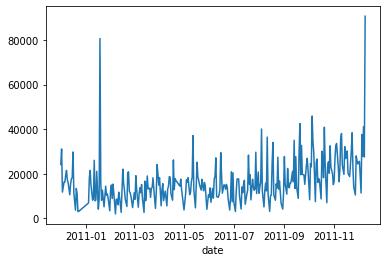

In [13]:
#일자별 총 거래 수량을 탐색 
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

#### 대체적으로연말에 가까워질수록 거래량이 증가한다. 10~11월 정도를 기점으로 증가폭이 조금씩 커기고 있다.

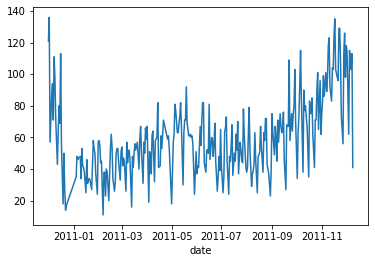

In [14]:
# 일자별 총 거래 횟수를 탐색
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

#### 거래 횟수는 연말에 가까워질수록 거래 수량보다 조금 더 가파르게 상승하고 있다.

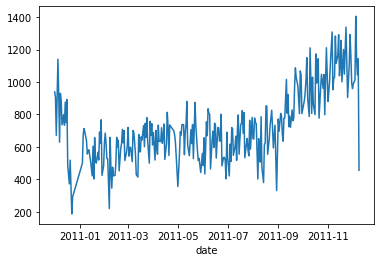

In [15]:
# 일자별 거래된 상품의 unique한 갯수, 즉 상품 거래 다양성 탐색
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

#### 지금까지의 그래프 중 가장 가파른 상승세를 나타내고 있다.
### 종합해보면, 연말이 시작되는 약 10~11월 정도부터 연중보다 더 많이, 더 자주 구매가 일어난다는 것을 알 수 있다.

----
##### 유저별 구매 패턴 분석

In [16]:
#총 유저의 수를 계산하여 출력
print(len(df['CustomerID'].unique()))

4334


In [17]:
# 유저별 거래 횟수를 탐색
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

#### CustomerID를 그룹으로 하여 unique한 InvoiceNo를 계산한 것. 이에 describe()함수를 적용하여 유저별 거래 횟수에 대한 요약 통계 정보를 출력
#### 출력 결과, 유저들은 평균적으로 약 4회 정도의 구매, 대부분의 유저는 1~5회 정도 구매 횟수를 보인다.

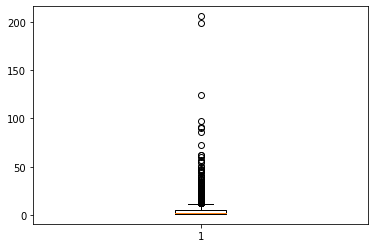

In [18]:
# 상자 그림 시각화
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

In [19]:
# 유저별 아이템 구매 종류 개수 탐색
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

#### 평균적으로 약 60여개 종류의 상품을 구매. 하지만 데이터의 편차는 매우 높은 수치를 보임.

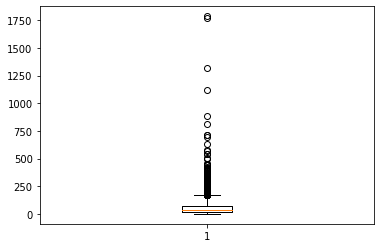

In [20]:
# 상자 그림 시각화
plt.boxplot(customer_unique_item_series.values)
plt.show()

### `[미니 퀴즈 - 5.2]`
- `이번에는 유저가 아닌 상품을 기준으로 EDA를 실시해 보세요.` 
    - 아래의 내용들을 탐색적으로 분석해보도록 합시다.
        - 총 상품 갯수
        - 가장 거래가 많은 상품 top 10 탐색
        - 상품별 판매수량 분포 탐색
        - 거래별 가격 탐색

In [21]:
#총 상품 개수
print(len(df['StockCode'].unique()))

3660


In [22]:
#가장 거래가 많은 상품 top10
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending = False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

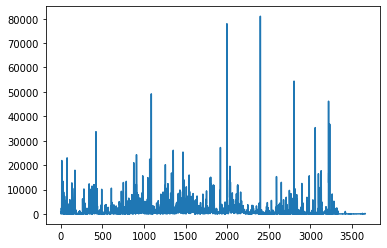

In [23]:
#상품별 판매수량 분포 탐색
df.groupby('StockCode')['Quantity'].sum().describe()
plt.plot(df.groupby('StockCode')['Quantity'].sum().values)
plt.show()

In [24]:
#거래별 가격 탐색
df['amount'] = df['Quantity'] * df['UnitPrice']
df.groupby('InvoiceNo')['amount'].sum().describe()

count     18405.000000
mean        476.378845
std        1678.749892
min           0.380000
25%         157.900000
50%         302.360000
75%         465.700000
max      168469.600000
Name: amount, dtype: float64

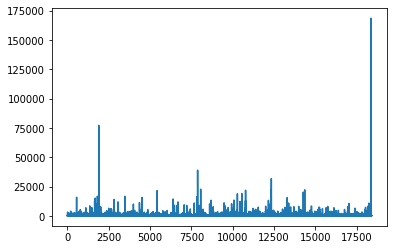

In [25]:
# 거래별로 발생한 가격 분포를 탐색
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)
plt.show()

----
##### 시계열 기준으로 데이터 분리
##### 11월 1일을 연말의 기준으로 삼아 두 개의 데이터로 분리. 추후 예측 분석에 사용할 학습 데이터셋, 테스트용 데이터셋을 의미하며 각 314,902개 81,568개

In [26]:
import datetime

# 2011년 11월을 기준으로 하여, 기준 이전과 이후로 데이터를 분리합니다.
df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 11)
(81568, 11)


##### 분리된 데이터에서 구매 패턴 탐색 : 재구매, 신규구매 등의 여부

In [27]:
# 11월 이전 데이터에서 유저별로 구매했던 상품의 set을 추출
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {23420, 84558A, 22423, 23297, 21636, 22376, 23...
12348    {22952, 21967, 21985, 21213, 22616, 21981, 849...
12350    {20652, 22551, 22620, 21171, 84086C, 21866, 21...
12352    {22635, 22784, 22423, 22120, 22413, 37448, 231...
12353                         {37449, 37450, 22890, 37446}
12354    {22635, 22661, 20677, 20750, 22384, 23204, 228...
12355    {22699, 22423, 72802B, 72802A, 22693, 22697, 8...
12356    {22699, 22195, 22423, 84457, 37501, 22066, 212...
12358    {15056N, 15060B, 21232, 15056P, 22063, 15056BL...
12359    {21906, 23420, 22625, 22423, 82613D, 22849, 23...
12360    {20677, 22813, 23372, 21987, 22554, 22555, 210...
12361    {22328, 20725, 22382, 22629, 22326, 22555, 207...
12362    {21866, 22423, 22565, 20728, 22276, 22554, 218...
12363    {22952, 22691, 21976, 21121, 21122, 21123, 212...
12364    {23307, 22620, 21976, 21121, 21122, 21987, 211...
12365    {22699, 21356, 22423, 84884A, 22697,

In [28]:
# 11월 이전에 구매했는지 혹은 이후에 구매했는지를 유저별로 기록하기 위한 사전을 정의
customer_item_dict = {}

# 11월 이전에 구매한 상품은 'old'라고 표기
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'23420': 'old', '84558A': 'old', '22423': 'old', '23297': 'old...


In [29]:
# 11월 이후 데이터에서 구매하는 상품의 set을 추출
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347    {23084, 21731, 23508, 84625A, 20719, 21265, 23...
12349    {84978, 22195, 22423, 23294, 23253, 22567, 212...
12352    {22635, 22627, 23088, 23559, 23368, 22982, 221...
12356                                       {22423, 21843}
12357    {20677, 22423, 23358, 23196, 21231, 23356, 231...
12358       {15056N, 20679, 22646, 15056BL, 22059, 15056P}
12362    {23303, 22659, 22962, 20750, 23358, 23264, 232...
12364    {16156S, 22045, 16161U, 22712, 22704, 22706, 2...
12367    {22045, 22629, 16237, 21579, 22708, 85227, 215...
12374    {22739, 22144, 22114, 22423, 22956, 21108, 233...
12375                 {21930, 20712, 23203, 23200, 85099C}
12380    {23084, 20685, 21731, 21621, 22628, 22326, 223...
12381    {22952, 23084, 22941, 21731, 22423, 22720, 843...
12384    {22632, 85099F, 23084, 20685, 21430, 22366, 15...
12388    {22086, 22340, 22576, 22338, 22910, 22669, 226...
12391    {20677, 23196, 22271, 22565, 21439, 23335, 231...
12395    {22661, 23559, 22423, 23372, 22899, 

In [30]:
# 11월 이전에만 구매한 상품은 'old', 이후에만 구매한 상품은 'new', 모두 구매한 상품은 'both'라고 표기

for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매기록이 있는 유저인지를 체크
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # 구매한 적 있는 상품인지를 체크한 뒤, 상태 표기
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'new'
    
    # 11월 이전 구매기록이 없는 유저라면 모두 'new'로 표기
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'23420': 'old', '84558A': 'old', '22423': 'old', '23297': 'old...


#### 구매 사전을 데이터 프레임으로 정리하기.

In [31]:
# 'old', 'new', 'both'를 유저별로 탐색하여 데이터 프레임을 생성
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

# 데이터 프레임을 생성하는 과정
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    # 딕셔너리의 상품 상태(old, new, both)를 체크하여 데이터 프레임에 append 할 수 있는 형태로 처리
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
    
    # df_order_info에 데이터를 append
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)

df_order_info.head()

,CustomerID,old,new,both
0,12346,1,0,0
1,12347,92,3,8
2,12348,21,0,0
3,12350,16,0,0
4,12352,43,12,2


### 완성된 데이터 프레임에서는 각 열에 유저별 'old', 'new', 'both'의 개수를 계산하여 저장하고 있다.

In [32]:
# 데이터 프레임에서 전체 유저 수 출력
print(df_order_info.shape[0])

# 데이터 프레임에서 old가 1 이상이면서, new가 1 이상인 유저 수 출력
# 11월 이후에 기존에 구매한적 없는 새로운 상품을 구매한 유저를 의미함.
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

# 데이터 프레임에서 both가 1 이상인 유저 수 출력. 
# 재구매한 상품이 있는 유저 수를 의미함
print(df_order_info[df_order_info['both'] > 0].shape[0])

4334
1446
1426


In [33]:
# new 피처의 value_counts를 출력하여, 새로운 상품을 얼마나 구매하는지 탐색
df_order_info['new'].value_counts()

0      2521
1        81
3        73
2        72
8        65
5        64
7        64
4        63
11       61
12       53
6        52
16       50
15       49
9        48
13       48
18       46
14       44
10       43
19       39
17       34
21       33
32       31
26       31
20       29
24       28
22       28
25       26
28       21
27       19
35       19
       ... 
197       1
131       1
130       1
203       1
126       1
124       1
123       1
98        1
121       1
118       1
312       1
63        1
74        1
77        1
82        1
87        1
89        1
90        1
94        1
95        1
97        1
99        1
101       1
102       1
107       1
108       1
113       1
115       1
116       1
391       1
Name: new, Length: 133, dtype: int64

In [34]:
# 만약 새로운 상품을 구매한다면, 얼마나 많은 종류의 새로운 상품을 구매하는지 탐색
print(df_order_info['new'].value_counts()[1:].describe())

count    132.000000
mean      13.734848
std       19.130672
min        1.000000
25%        1.000000
50%        5.000000
75%       16.000000
max       81.000000
Name: new, dtype: float64


### 실행 결과, 평균적으로 13개 종류의 신규 상품을 구매. 하지만 편차가 매우 크다. 즉, 신규 구매를 하는 유저들은 일반적으로 많은 종류의 상품을 구매하지는 않을 것으로 예상할 수 있다.

# [Step2. 예측 분석] : SVD를 활용한 상품 구매 예측
### [피처 엔지니어링]


In [35]:
# 추천 대상 데이터에 포함되는 유저와 상품의 개수 출력
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


### 이 데이터는 'Rating'에 해당하는 선호도 점수를 가지고 있지 않기 때문에 피처 엔지니어링을 통해 이 점수를 만들어내야 한다.
### '유저별 구매 횟수는 일반적으로 1~5 사이에 분포
### 우리는 이 정보를 이용하여 유저-상품 간의 구매 횟수가 Rating으로 사용하기에 적절한지를 탐색할 것이다. 
    유저별 구매 횟수가 일반적으로 1~5 사이라면 유저-상품 간의 구매 횟수 역시 크게 다르지 않을 것이기 때문.

##### SVD 모델에 사용할 데이터 : User-Item간의 Rating 데이터 생성 (U-I-R Matrix)

In [36]:
# Rating 데이터를 생성하기 위한 탐색 : 유저-상품간 구매 횟수를 탐색
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346,23166,1
1,12347,16008,1
2,12347,17021,1
3,12347,20665,1
4,12347,20719,3


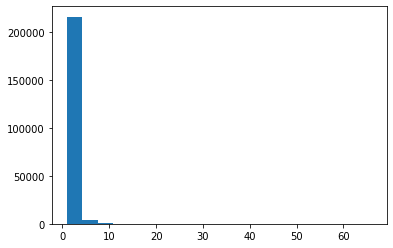

In [37]:
# Rating(InvoiceNo) 피처의 분포를 탐색
uir_df['InvoiceNo'].hist(bins=20, grid=False)

### 대부분의 점수가 1~5 사이에 위치하기는 하지만 점수가 낮은 쪽으로 많이 쏠려있는 것을 확인할 수 있다. 이러한 분포를 가진 Rating으로 SVD 모델을 학습한다면, 행렬을 제대로 완성하지 못할 확률이 높다.
### 이를 개선하기 위해, 피처 엔지니어링 기법으로 로그를 통한 피처 정규화 방법이 있다. 
    목적 : 데이터 사이의 편차를 줄여 왜도(비대칭 분포 정도)를 감소시키는 것.

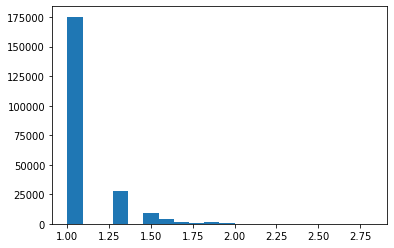

In [38]:
# Rating(InvoiceNo) 피처를 log normalization 해준 뒤, 다시 분포를 탐색합니다.
uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=False)

### 여전히 왜도가 높긴 하지만 이전에 비해서는 피처를 Rating으로 쓰기에 조금 더 적합해졌다. 
### 정규화 적용 후, 다시 피처 스케일링을 적용하여 1~5 사이의 값으로 변환. 최대-최소 스케일링 방법 적용

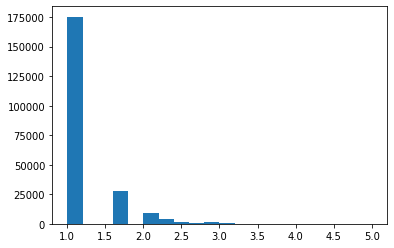

In [39]:
# 1~5 사이의 점수로 변환
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / 
                    (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)

----
### [SVD 모델 학습하기]

In [40]:
# SVD 모델 학습을 위한 데이터셋을 생성
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346,23166,1.000000
1,12347,16008,1.000000
2,12347,17021,1.000000
3,12347,20665,1.000000
4,12347,20719,2.048881


In [107]:
!pip install surprise

  Using cached https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/97/37/5d334adaf5ddd65da99fc65f6507e0e4599d092ba048f4302fe8775619e8/scikit-surprise-1.1.1.tar.gz
  Running setup.py bdist_wheel for scikit-surprise: started
  Running setup.py bdist_wheel for scikit-surprise: finished with status 'error'
  Complete output from command C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\USER\\AppData\\Local\\Temp\\pip-build-qt8lv6vz\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\USER\AppData\Local\Temp\tmp5c_vqo60pip-wheel- --python-tag cp36:
  C:\ProgramData\Anaconda3\lib\distutils\dist.py:261: UserWarning: Unknown distribution option: 'long_description_content_type'
    warn

  Failed building wheel for scikit-surprise
Command "C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\USER\\AppData\\Local\\Temp\\pip-build-qt8lv6vz\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\USER\AppData\Local\Temp\pip-un23vb7c-record\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\USER\AppData\Local\Temp\pip-build-qt8lv6vz\scikit-surprise\
You are using pip version 9.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [41]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성. 대략적인 성능을 알아보기 위해 학습 데이터와 테스트 데이터를 8:2로 분할
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력하여 모델의 성능 평가
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 122.95 seconds
RMSE of test dataset in SVD model:
RMSE: 0.3369


0.33688358166554927

In [42]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 11월 이전 전체를 full trainset으로 활용
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 162.85 seconds


# [Step3. 예측 평가하기] : 상품 추천 시뮬레이션

### 추천의 대상 유저는 11월 이전 데이터에 등장한 모든 유저
### 유저들에게 추천의 대상이 되는 상품은 3가지로 분류
    1. 이전에 구매한 적 없던 상품 추천: 신규 구매를 타겟으로 하는 추천
    2. 이전에 구매했던 상품 추천: 재구매를 타겟으로 하는 추천
    3. 모든 상품을 대상으로 상품 추천: 모든 유저-상품의 점수를 고려하여 추천

### [상품 추천 시뮬레이션]
    
    11월 이전 데이터에서 유저-상품에 대한 Rating을 기반으로 추천 상품을 선정합니다.

1. 이전에 구매하지 않았던 상품 추천 : anti_build_testset()을 사용합니다.
2. 이전에 구매했던 상품 다시 추천 : build_testset()을 사용합니다.
3. 모든 상품을 대상으로 하여 상품 추천

#### 첫 번째 추천 대상의 유저-상품 점수 추출

In [43]:
#이전에 구매하지 않았던 상품을 예측의 대상으로 선정
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

In [45]:
#구매 예측 결과를 딕셔너리 형태로 변환
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
print(str(new_order_prediction_dict)[:300] + "...")

{'12346': {'16008': 1, '17021': 1.1716239280007463, '20665': 1.0270122421427053, '20719': 1.2131611006337717, '20780': 1, '20782': 1.1523224708959117, '20966': 1.0513602711548538, '21035': 1.04398156468488, '21041': 1.0245447169136614, '21064': 1.0404149071019537, '21154': 1.0880580953643793, '21171...


#### 두 번째 추천 대상의 유저-상품 점수 추출

In [46]:
#이전에 구매했었던 상품을 예측의 대상으로 선정
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

In [47]:
#구매 예측 결과를 딕셔너리 형태로 변환
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{'12346': {'23166': 1.0601333173480172}, '12347': {'16008': 1.0940432595211762, '17021': 1.3320159782675918, '20665': 1.0232382150214927, '20719': 2.0857518288603845, '20780': 1.0317123381710782, '20782': 1.2260966421150201, '20966': 1.2972587544770788, '21035': 1.317405995241851, '21041': 1.5159070...


#### 세 번째 추천 대상의 유저-상품 점수 추출

In [49]:
#두 딕셔너리를 하나로 통합
total_prediction_dict = {}

#new_order_prediction_dict 정보를 새로운 딕셔너리에 저장
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating

#reorder_prediction_dict 정보를 새로운 딕셔너리에 저장
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{'12346': {'16008': 1, '17021': 1.1716239280007463, '20665': 1.0270122421427053, '20719': 1.2131611006337717, '20780': 1, '20782': 1.1523224708959117, '20966': 1.0513602711548538, '21035': 1.04398156468488, '21041': 1.0245447169136614, '21064': 1.0404149071019537, '21154': 1.0880580953643793, '21171...


In [50]:
# 11월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터프레임을 생성
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,12347,"{23084, 21731, 23508, 84625A, 20719, 21265, 23..."
1,12349,"{84978, 22195, 22423, 23294, 23253, 22567, 212..."
2,12352,"{22635, 22627, 23088, 23559, 23368, 22982, 221..."
3,12356,"{22423, 21843}"
4,12357,"{20677, 22423, 23358, 23196, 21231, 23356, 231..."


### 위 데이터프레임은 각 유저들이 11월 이후에 실제로 구매한 상품의 리스트를 데이터 프레임 형태로 저장한 것.

### 시뮬레이션 결과 추가하기

In [51]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수 정의
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

### 이 함수는 유저의 id와 위에서 추출했던 딕셔너리 중 1개를 인자로 입력 받는다. 그리고 딕셔너리 안에서의 유저 정보를 참고하여 예측된 점수순으로 상품을 정렬하고 리스트 형태로 반환한다.

In [52]:
# 상품 추천 시뮬레이션 결과를 추가합니다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,12347,"{23084, 21731, 23508, 84625A, 20719, 21265, 23...","[22326, 22197, 22356, 20724, 22355, 20725, 211...","[22726, 20719, 21731, 22728, 22371, 22423, 219...","[22326, 22197, 22356, 20724, 22355, 20725, 211..."
1,12349,"{84978, 22195, 22423, 23294, 23253, 22567, 212...",None,None,None
2,12352,"{22635, 22627, 23088, 23559, 23368, 22982, 221...","[84086B, 85131B, 82486, 85175, 17084R, 48116, ...","[37448, 22779, 22645, 84050, 22780, 22993, 212...","[84086B, 85131B, 82486, 85175, 17084R, 48116, ..."
3,12356,"{22423, 21843}","[84086B, 85131B, 90119, 90035A, 90042A, 22197,...","[22423, 22699, 22698, 22649, 37450, 21080, 209...","[84086B, 85131B, 90119, 90035A, 90042A, 22197,..."
4,12357,"{20677, 22423, 23358, 23196, 21231, 23356, 231...",None,None,None


### [상품 추천 평가하기]
    추천 시뮬레이션이 실제 구매와 얼마나 비슷하게 예측되었는지를 평가
    1. 유저별로 예측된 상품의 점수 순으로 상위 k개의 상품을 추천 대상으로 정의
    2. 추천한 k개의 상품 중, 실제 구매로 얼마만큼 이어졌는지 평가.
    
    다음의 calculate_recall()함수는 이 과정을 코드로 정의한 것.
    real_order 파라미터는 실제 구매한 상품의 리스트이고, predicted_order 파라미터는 예측 점수순으로 정렬된 상품의 리스트이다.
    그리고 k파라미터는 추천할 개수를 의미한다.
    만약 추천할 대상 상품 리스트가 없다면 11월 이전 데이터셋에 존재하지 않는 유저이기 때문에 None
    추천할 상품 리스트가 존재한다면 리스트 중 상위 k개를 선정하여 실제 구매한 리스트에 몇 개나 존재하는지 계산하여 반환

### 

In [53]:
# 구매 예측의 상위 k개의 recall(재현율)을 평가 기준으로 정의
def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 유저
    if predicted_order is None:
        return None
    
    # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 "구매 할 것으로 예측"
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율(recall)을 계산
    recall = true_positive / len(predicted)
    return recall

# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

In [54]:
# 평가 결과를 유저 평균으로 살펴보자.
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.3099675324675303
0.009090909090909087
0.07415584415584447


### 이는 세 가지 추천 시뮬레이션의 평균 재현도를 각각 계산하여 출력한 것.
### 이미 한 번 구매했던 상품을 대상으로 하여 추천해주었을 때, 평균 재현도는 약 31%, 신규 구매를 대상으로 할 때는 0.9%, 전체 상품을 대상으로 할 때는 약 7% 정도로 나타남.
### 이를 통해 재구매할만한 상품을 추천해주는 것이 새로운 상품을 추천해주는 것보다 더 좋은 결과를 낼 것이라고 예상 가능.

In [56]:
#재구매 상품 추천의 상세 결과
# 평가 결과를 점수 기준
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    472
0.200000    386
0.400000    299
0.600000    184
0.800000     93
1.000000     87
0.500000      7
0.250000      6
0.666667      4
0.333333      1
0.750000      1
Name: top_k_recall(Reorder), dtype: int64

    재현도 0: 472명은 5개를 추천해준다면 하나도 구매하지 않을 것으로 예상
    재현도 0.2: 386명은 5개를 추천해준다면 1개의 상품을 구매할 것으로 예상
### 위 결과, 5개의 상품을 추천한다면 과반수 이상은 실제 구매로 이어질 것으로 예상되기 때문에 이 시뮬레이션 결과는 제법 성공적인 예측이다.

In [57]:
simulation_test_df['top_k_recall(New)'].value_counts()

0.0    1482
0.2      49
0.4       6
0.6       3
Name: top_k_recall(New), dtype: int64

### 위 결과, 전체적으로 0에 가까운 재현도를 보인다. 이 시뮬레이션 결과는 좋지 않은 것으로 평가할 수 있다.

In [58]:
simulation_test_df['top_k_recall(Total)'].value_counts()

0.0    1195
0.2     202
0.4      92
0.6      27
0.8      16
1.0       8
Name: top_k_recall(Total), dtype: int64

### 두 번째 시뮬레이션 결과보다는 조금 낫지만 이번 시뮬레이션 결과 역시 그다지 좋지 않은 것으로 보임.

### 3개의 시뮬레이션 평가 결과, 재구매할만한 상품을 추천해 주는 것이 가장 좋은 시뮬레이션인 것으로 평가됨.

----
##### 시뮬레이션 결과 살펴보기

In [59]:
# 추천 시뮬레이션 결과
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 
                       'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]
result_df.sample(5).head()

,구매자ID,실제주문,5개추천결과,Top5추천_주문재현도
445,13709,"{90191, 90199B, 22483, 23566, 90158, 23393, 22...","[21672, 22771, 21670, 22192, 21671]",0.4
236,13018,"{22274, 21175, 22144, 21155, 23504, 20726, 222...","[47566, 21175, 84755, 22469, 22720]",0.2
1561,17243,"{84029G, 84879, 21377, 23329, 22114, 22865, 23...","[85123A, 82494L, 82484, 21754, 22112]",0.6
593,14188,"{22602, 20725, 23209, 23343, 23203, 71477, 235...","[85099B, 20725, 22386, 23202, 23203]",0.6
1601,17371,"{21621, 22423, 22271, 22607, 84596B, 21914, 23...","[37370, 90125D, 20782, 21735, 21872]",0.0
